In [242]:
using Test,Plots,SignalAnalysis,DSP

In [2]:
randn(ComplexF32,(2,2))

2×2 Matrix{ComplexF32}:
  0.282872-0.468163im   -1.35457+1.64385im
 -0.824391+0.647333im  -0.321481+0.262763im

In [3]:
makeInput(size::Number) = convert(BitArray, rand(Bool,size));
InputBits = makeInput(4*100);
typeof(InputBits)

BitVector (alias for BitArray{1})

In [4]:
collect(Iterators.partition(InputBits,4));

In [111]:
toBitArray(value::Number, size::Int) = BitVector([value & (1<<bit) != 0 for bit in 0:(size-1)])
toBitArray2(value::Number, size::Int) = BitVector( digits(value,base=2,pad=size) )

toBitArray2 (generic function with 2 methods)

In [51]:
@time toBitArray2(1234567890123456789,64);
@time toBitArray(1234567890123456789,64);

  0.000005 seconds (3 allocations: 672 bytes)
  0.000004 seconds (3 allocations: 224 bytes)


In [5]:
qpsk(i::Number)::ComplexF32 = 1/√2*(1-2(i÷2) + im*(1-2(i%2)))
qpsk(bits::BitVector)::Vector{ComplexF32}=[1/√2*(1-2p + im*(1-2q)) for (p,q) in Iterators.partition(bits,2)]

qpsk (generic function with 2 methods)

In [39]:
qpsk.([0 1 2 3])

1×4 Matrix{ComplexF32}:
 0.707107+0.707107im  0.707107-0.707107im  …  -0.707107-0.707107im

In [42]:
function qam16(bits::BitArray)::Vector{ComplexF32}
    v(p::Bool,q::Bool) = (p ? -1 : 1)*(q ? 3 : 1)
    [1/√10*(v(quad[1],quad[3])+im*v(quad[2],quad[4])) for quad in Iterators.partition(bits,4)]
end
qam16(bits::Matrix{T}) where {T<:Number} = qam16(convert(BitArray,bits))
qam16(vect::Vector) = qam16.(vect)
qam16(val::Number) = qam16(toBitArray(val,4))

qam16 (generic function with 5 methods)

In [40]:
bitv=BitVector([true,false,true])

3-element BitVector:
 1
 0
 1

In [41]:
boolv=Bool[1,0,1]
varinfo(r"bitv"), varinfo(r"boolv")

(| name |     size | summary             |
|:---- | --------:|:------------------- |
| bitv | 72 bytes | 3-element BitVector |
, | name  |     size | summary                |
|:----- | --------:|:---------------------- |
| boolv | 43 bytes | 3-element Vector{Bool} |
)

In [10]:
Base.summarysize(boolv),Base.summarysize(bitv)

(43, 72)

In [116]:
qpsk(boolv)

LoadError: MethodError: no method matching qpsk(::Vector{Bool})
[0mClosest candidates are:
[0m  qpsk([91m::Number[39m) at In[5]:1
[0m  qpsk([91m::BitVector[39m) at In[5]:2

In [12]:
@test qpsk(0) == qpsk(BitVector([false,false]))[1];

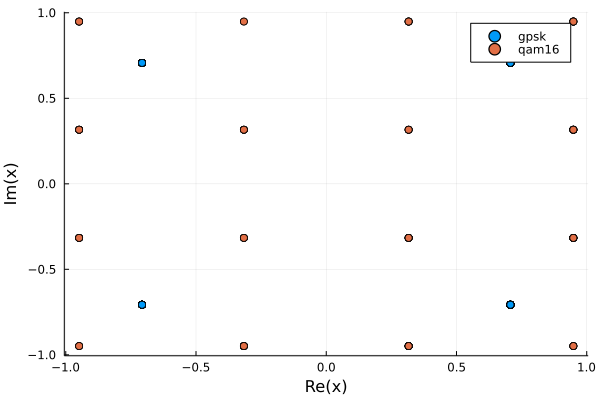

In [13]:
scatter(qpsk(InputBits),label="gpsk")
scatter!(qam16(InputBits),label="qam16")

In [52]:
@which qam16([0 0 0 0 0 0 0 1])

qam16(bits::Matrix{T}) where T<:Number in Main at In[42]:5

In [54]:
@which qam16( Bool[0 0 0 0 0 0 0 1] )

qam16(bits::Matrix{T}) where T<:Number in Main at In[42]:5

In [15]:
@show typeof(InputBits)

typeof(InputBits) = BitVector


BitVector (alias for BitArray{1})

In [16]:
mod = qam16(InputBits);

In [17]:
function signal_power(signal::Array, normed::Bool=true)
    pwr = real(sum(signal .* conj(signal)))
    if normed
        pwr /= 2*length(signal)+1
    end
    pwr  
end

signal_power (generic function with 2 methods)

In [18]:
awgn(size::Number, sinr::Real) = randn(ComplexF32,size)*sinr
function awgn(signal::Array, sinr::Real)
    pwr = signal_power(signal)
    T = eltype(signal)
    amp = sqrt(pwr/db2pow(sinr))
    signal + randn(T,length(signal))*amp
end
db2pow(a::Real) = exp10(a/10)
pow2db(a::Real) = 10log10(a)
db2amp(a::Real) = exp10(a/20)
amp2db(a::Real) = 20log10(a);

In [19]:
signal_power(mod)

0.48159206f0

In [20]:
@show signal_power(mod)/db2pow(15);

signal_power(mod) / db2pow(15) = 0.015229278099184815


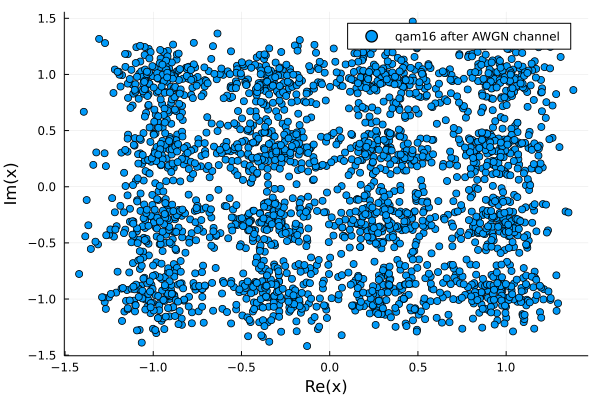

In [35]:
scatter(awgn(10000 |> makeInput |> qam16,10), label="qam16 after AWGN channel")

In [22]:
average(signal) = sum(signal)/length(signal);

In [36]:
@show signal_power(mod);
@show signal_power(chanOut);
@show pow2db(signal_power(chanOut)/signal_power(mod));

signal_power(mod) = 0.48159206f0


LoadError: UndefVarError: chanOut not defined

In [97]:
Qam16Symbols = 0:15 .|> qam16;
collect(0:15) |> qam16;

In [159]:
function calcLLR(symbol::Complex{T},variance::Real,allSymbols::Dict{BitVector,Complex{T}}) where {T}
    bits,s = first(allSymbols)
    expf(d) = exp(-real(d*conj(d))/variance)
    eexp = Dict( b=>expf(symbol-s) for (b,s) in allSymbols )
    ones = Dict(b=>filter(e->e[b],bv) for b in 1:4)
    zeros = Dict(b=>filter(e->~e[b],bv) for b in 1:4)
    nbits = length(bits)
    LLRs = Base.zeros(nbits)
    for bit in 1:nbits
        p1 = sum( eexp[b] for b in ones[bit] )
        p0 = sum( eexp[b] for b in zeros[bit] )
        LLRs[bit] = p0 / p1
    end
    LLRs
end

calcLLR (generic function with 1 method)

In [160]:
calcLLR(0.5f0+0.5f0im,0.8,allQam16Symbols)

4-element Vector{Float64}:
 3.421753686464111
 3.4217536864641116
 1.6392592818646072
 1.6392592818646072

In [108]:
0b0001

0x01

In [112]:
qam16(Int8[0b0000,0b0001])

2-element Vector{Vector{ComplexF32}}:
 [0.31622776f0 + 0.31622776f0im]
 [-0.31622776f0 + 0.31622776f0im]

In [115]:
makeInput(size::Number) = convert(BitArray, rand(Bool,size));
inp = makeInput(4*1000);
symbols = qam16(inp);

In [281]:
unzip(a) = [getindex.(a, i) for i in 1:length(a[1])]

unzip (generic function with 1 method)

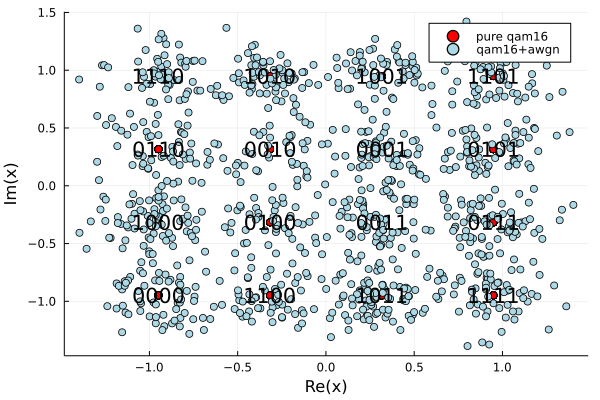

In [275]:
rsymbols = awgn(symbols,10)
scatter(symbols,color="red", label="pure qam16")
an = [(real(s[1]),imag(s[1]),bitstring(Int8(v))[end-3:end]) for (v,s) in enumerate(qam16.(0:15))];
annotate!(an...)
scatter!(rsymbols,color="light blue", label="qam16+awgn")
#LLRs = calcLLR.(symbols,varia)

  0.054680 seconds (140.66 k allocations: 8.028 MiB, 90.40% compilation time)


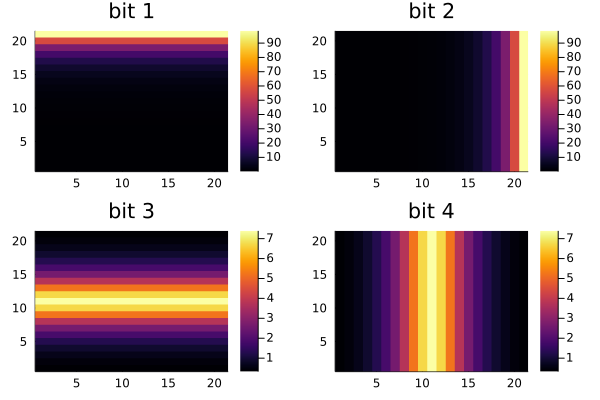

In [278]:
mesh=Iterators.product(-1:0.1:1, -1:0.1:1)
calcLLRqam16(s,v)=calcLLR(ComplexF32(s...),v,allQam16Symbols);
@time LLRs = calcLLRqam16.(mesh,0.4)
b=unzip(LLRs);
Plots.plot([Plots.heatmap(b[i], title="bit $i") for i in 1:4]..., layout=(2,2))

In [306]:
coords = getindex.(0:15 .|> qam16,1) .|> reim

16-element Vector{Tuple{Float32, Float32}}:
 (0.31622776, 0.31622776)
 (-0.31622776, 0.31622776)
 (0.31622776, -0.31622776)
 (-0.31622776, -0.31622776)
 (0.9486833, 0.31622776)
 (-0.9486833, 0.31622776)
 (0.9486833, -0.31622776)
 (-0.9486833, -0.31622776)
 (0.31622776, 0.9486833)
 (-0.31622776, 0.9486833)
 (0.31622776, -0.9486833)
 (-0.31622776, -0.9486833)
 (0.9486833, 0.9486833)
 (-0.9486833, 0.9486833)
 (0.9486833, -0.9486833)
 (-0.9486833, -0.9486833)

In [302]:
ones = [[v+1 for v in 0:15 if v & (1<<bit) != 0] for bit in 0:3]

4-element Vector{Vector{Int64}}:
 [2, 4, 6, 8, 10, 12, 14, 16]
 [3, 4, 7, 8, 11, 12, 15, 16]
 [5, 6, 7, 8, 13, 14, 15, 16]
 [9, 10, 11, 12, 13, 14, 15, 16]

In [303]:
Plots.plot([scatter(coords[ones[i]]) for i in range 1:4]..., layout=(2,2))

8-element Vector{Int64}:
  2
  4
  6
  8
 10
 12
 14
 16